In [13]:
import numpy as np
import sympy as sp
from numpy.linalg import inv
from numpy import matmul as mul

import time
import matplotlib.pyplot as plt

# Printing Matrices Nicely ______________________________________________________________________________
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
# Surface Green's Function Calculations _________________________________________________________________
def surface_greens_func_calc_general(Energy,z,n_atoms,Periodicity,N_periods,oneD_test,Gamma,Beta,potential,error_output,print_output):
    # Calculates surface green's function in general with entirely random input matrices to construct Hamiltonian

    # Energy - input energy in eV
    # z - imaginary componenet added to energy, usually between e-3 and e-8
    # n_atoms - number of atoms per layer
    # Periodicity - periodicity, after how many layers is there repition
    # N_periods - total number of periods in Hamiltonian
    # oneD_test (T/F) - Testing 1 dimensional case with set tau structure
    # Gamma - value of Gamma in 1d test case
    # Beta - value of Beta in 1d test case
    # potential - value of potential in 1d test case
    # error_output - output error instead of green's surface functions
    # print_output - print ressults for different methods
    
    # OUTPUT - array containing surface green's functions calculated in different methods.
    
    E = Energy+z*1j

    n = n_atoms # Atoms per layer
    P = Periodicity # Periodicity
    if oneD_test == True:
        n = 1
        P = 2
    N = N_periods # Number of periods

    # Create Hamiltonian
    alpha = np.zeros((n,n,P),dtype=complex)
    tau = np.zeros((n,n,P),dtype=complex)
    if oneD_test == False:
        for i in range(P):
            alpha[:,:,i] = (np.random.random((n,n)))+1j*(np.random.random((n,n)))
            tau[:,:,i] = (np.random.random((n,n)))+1j*(np.random.random((n,n)))
    else:
        for i in range(P):
            alpha[:,:,i] = np.diag(potential*np.ones(n))
            if i%2 == 0:
                tau[:,:,i] = np.diag(Beta*np.ones(n))
            else:
                tau[:,:,i] = np.diag(Gamma*np.ones(n))

    H = np.zeros((N*P*n,N*P*n),dtype=complex)
    for i in range(N):
        for k in range(P):
            H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+k*n:i*P*n+(k+1)*n] = alpha[:,:,k]

            if i*P+(k+1)<P*N:
                H[i*P*n+k*n:i*P*n+(k+1)*n,i*P*n+(k+1)*n:i*P*n+(k+2)*n] = tau[:,:,k]
                H[i*P*n+(k+1)*n:i*P*n+(k+2)*n,i*P*n+k*n:i*P*n+(k+1)*n] = tau[:,:,k].T.conj()

    # Condensation Algorithm ##################################################################
    t0_condensation = time.time()
    
    # Recursive inversion of C matrix
    H_tilde = np.zeros((n,n,P,P),dtype=complex)
    H_tilde[:,:,P-1,P-1] = inv(E*np.diag(np.ones(n))-alpha[:,:,P-1])

    for i in range(P-2,0,-1):
        H_tilde[:,:,i,i] = inv(E*np.diag(np.ones(n))-alpha[:,:,i]-mul(tau[:,:,i],mul(H_tilde[:,:,i+1,i+1],tau[:,:,i].T.conj())))
        H_tilde[:,:,i,P-1] = mul(H_tilde[:,:,i,i],mul(tau[:,:,i],H_tilde[:,:,i+1,P-1]))

    C_tilde = np.zeros((n,n,P),dtype=complex)
    C_tilde[:,:,1] = H_tilde[:,:,1,1]

    for i in range(2,P):
        C_tilde[:,:,i] = H_tilde[:,:,i,i]+mul(H_tilde[:,:,i,i],mul(mul(tau[:,:,i-1].T.conj(),mul(C_tilde[:,:,i-1],tau[:,:,i-1])),H_tilde[:,:,i,i]))  
        
    # Makes Condensation Matices
    Xi_s = alpha[:,:,0]+mul(tau[:,:,0],mul(H_tilde[:,:,1,1],tau[:,:,0].T.conj()))
    Xi = Xi_s+mul(tau[:,:,P-1],mul(C_tilde[:,:,P-1],tau[:,:,P-1].T.conj()))
    Pi = mul(tau[:,:,0],mul(H_tilde[:,:,1,P-1],tau[:,:,P-1]))

    # Condensed Matrix    
    H_conds = np.zeros((N*n,N*n),dtype=complex)
    for i in range(N):
        if i == 0:
            H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi_s
        else:
            H_conds[i*n:(i+1)*n,i*n:(i+1)*n] = Xi
            H_conds[(i-1)*n:i*n,i*n:(i+1)*n] = Pi
            H_conds[i*n:(i+1)*n,(i-1)*n:i*n] = Pi.T.conj()
            
    t1_condensation = time.time()

    # Eigenvalue Formulation ##################################################################
    # Eigenvalue Matrices
    t0_eig = time.time()
    
    A = np.zeros((2*n,2*n),dtype=complex)
    A[0:n,n:2*n] = np.diag(np.ones(n))
    A[n:2*n,0:n] = -Pi.T.conj()
    A[n:2*n,n:2*n] = E*np.diag(np.ones(n))-Xi

    B = np.zeros((2*n,2*n),dtype=complex)
    B[0:n,0:n] = np.diag(np.ones(n))
    B[n:2*n,n:2*n] = Pi

    # Selcting eigenvalues with mag of less than one
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(B) @ A)
    U = eigenvectors
    Lambda = eigenvalues
    #U = np.linalg.eig(mul(inv(B),A)).eigenvectors
    #Lambda = np.linalg.eig(mul(inv(B),A)).eigenvalues
    
    if oneD_test == True:
        indices = np.where(Lambda == min(Lambda))
        U = U[0:n,indices[0]]
        Lambda = np.diag(Lambda[indices[0]])
    else:
        indices = np.where(np.abs(Lambda) < 1)
        index = indices[0]
        
        # remove extra vectors
        if len(index) > n:
            index = index[0:n]  
        
        U = U[0:n,index]
        Lambda = np.diag(Lambda[index])

    # Pseudo invert U
    Q,R = np.linalg.qr(U)
    if R.shape[0] != R.shape[1]:
        Q,R = np.linalg.qr(U)

    U_tilde = mul(inv(R),Q.T.conj())

    # Self Energy Matrix
    F = mul(U,mul(Lambda,U_tilde))
    Sigma_dash = mul(Pi,F)

    # Green's function
    g_00_eig = inv(E*np.diag(np.ones(n))-Xi_s-Sigma_dash)
    
    t1_eig = time.time()
    
    
    
    print(Sigma_dash)
    
    
    

    # Decimation Formulation ##################################################################
    # Initial matrices
    t0_decimation = time.time()
    
    mu_0 = E*np.diag(np.ones(n))-Xi_s
    nu_0 = E*np.diag(np.ones(n))-Xi
    gamma_0 = Pi

    mu_old = mu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))
    nu_old = nu_0-mul(gamma_0,mul(inv(nu_0),gamma_0.T.conj()))-mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0))
    gamma_old = mul(gamma_0,mul(inv(nu_0),gamma_0))
    zeta_old = mul(gamma_0.T.conj(),mul(inv(nu_0),gamma_0.T.conj()))

    # Iterative Procedure
    iterations = 0
    error = 1
    while(error>10**-8):
        mu_new = mu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))
        nu_new = nu_old-mul(gamma_old,mul(inv(nu_old),gamma_old.T.conj()))-mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old))
        gamma_new = mul(gamma_old,mul(inv(nu_old),gamma_old))
        zeta_new = mul(gamma_old.T.conj(),mul(inv(nu_old),gamma_old.T.conj()))

        error = abs(np.sum(mu_new-mu_old))
        
        mu_old = mu_new
        nu_old = nu_new
        gamma_old = gamma_new
        zeta_old = zeta_new
        
        iterations += 1
        
    g_00_dec = inv(mu_new)
    
    t1_decimation = time.time()

    # Recursive (Datta) Formulation ##################################################################
    if oneD_test == True:
        g_old = (E-Gamma**2)**(-1)

        for i in range(iterations):
            if i%2 == 0:
                g_new = (E-Gamma**2*g_old)**(-1)
            else:
                g_new = (E-Beta**2*g_old)**(-1)
            g_old = g_new

        g_00_rec = g_new

    # Direct Formulation ##################################################################
    t2_condensation = time.time()
    g_surf_conds = inv(E*np.diag(np.ones(N*n))-H_conds)
    g_surf_conds_dir = g_surf_conds[0:n,0:n]
    t3_condensation = time.time()    

    t0_direct = time.time()
    g_surf = inv(E*np.diag(np.ones(N*P*n))-H)
    g_surf_dir = g_surf[0:n,0:n]
    t1_direct = time.time()

    if oneD_test == True:
        g_quadratic = 1/(2*Gamma**2*(E-potential))*((E-potential)**2+Gamma**2-Beta*np.conj(Beta)-np.sqrt(((E-potential)**2+Gamma**2-Beta*np.conj(Beta))**2-4*Gamma**2*(E-potential)**2))    
    
    if print_output == True:
        print("Eigenvalue Method")
        #matprint(g_00_eig)
        print("Error from Cond")
        print(np.sum(abs(g_00_eig-g_surf_conds_dir))/n**2)
        print("Error from Direct")
        print(np.sum(abs(g_00_eig-g_surf_dir))/n**2)
        print("Time")
        print(t1_condensation-t0_condensation+t1_eig-t0_eig)
        print("___________________________")
        print("Decimation Method")
        #matprint(g_00_dec)
        print("# Iterations before epsilon < 10^-8")
        print(iterations)
        print("Error from Cond")
        print(np.sum(abs(g_00_dec-g_surf_conds_dir))/n**2)
        print("Error from Direct")
        print(np.sum(abs(g_00_dec-g_surf_dir))/n**2)   
        print("Time")
        print(t1_condensation-t0_condensation+t1_decimation-t0_decimation)
        print("___________________________")
        if oneD_test == True:
            print("Recursive Relation Datta")
            print(g_00_rec)
            print("Error from Direct")
            print(np.sum(abs(g_00_rec-g_surf_dir))/n**2)
            print("___________________________")
        print("Direct Condensed Method")
        #matprint(g_surf_conds_dir)
        print("Error from Direct")
        print(np.sum(abs(g_surf_conds_dir-g_surf_dir))/n**2)
        print("Time")
        print(t1_condensation-t0_condensation+t3_condensation-t2_condensation)
        print("___________________________")
        print("Direct Method")
        #matprint(g_surf_dir)
        print("Time")
        print(t1_direct-t0_direct)
        print("___________________________")
        if oneD_test == True:
            print("Quadratic Formulation")
            print(g_quadratic)
    
    if error_output == False:
        if oneD_test == False:    
            return([g_00_eig[0:n,0:n],g_00_dec[0:n,0:n],g_surf_conds_dir[0:n,0:n],g_surf_dir[0:n,0:n]])  
        else:
            return([g_00_eig[0,0],g_00_dec[0,0],g_00_rec,g_quadratic,g_surf_conds_dir[0,0],g_surf_dir[0,0]])
    else:
        return([np.sum(abs(g_00_eig-g_surf_conds_dir))/n**2,np.sum(abs(g_00_eig-g_surf_dir))/n**2,iterations,np.sum(abs(g_00_dec-g_surf_conds_dir))/n**2,np.sum(abs(g_00_dec-g_surf_dir))/n**2,np.sum(abs(g_surf_conds_dir-g_surf_dir))/n**2])  

In [14]:
# Error Calculation and Convergence Study
nsteps = 300

error_array_n = np.zeros((6,nsteps+1))
error_array_p = np.zeros((6,nsteps+1))
error_array_N = np.zeros((6,nsteps+1))

for i in range(3,nsteps+1):
    #error_array_p[:,i] = surface_greens_func_calc_general(-4,10**(-i),17,4,2,False,1,1.1,True,False)
    error_array_N[:,i] = surface_greens_func_calc_general(-4,10**-8,2,2,i,False,1,1.1,0,True,False)

[[-0.01265674+0.0031023j  -0.01827815+0.00838437j]
 [-0.0193412 +0.00237529j -0.0313057 +0.00938662j]]
[[-0.0103469 +0.00248285j -0.01266787+0.010282j  ]
 [-0.01601554-0.00256865j -0.02457612+0.00696769j]]
[[-0.00067947+0.00026719j -0.00235444+0.0025898j ]
 [-0.00361231-0.00028939j -0.01837465+0.00645992j]]
[[-0.03474504+0.01281079j -0.02086885+0.00427555j]
 [-0.01800903+0.01049342j -0.01233096+0.004432j  ]]
[[-0.0173177 +0.00761942j -0.00713651+0.00744013j]
 [-0.00889177+0.0005936j  -0.00975887+0.0027936j ]]
[[-0.00757339+0.00201229j -0.01175521-0.00210588j]
 [-0.00922875+0.00813536j -0.01828114+0.00530464j]]
[[-0.02389478+0.00544059j -0.02314037-0.00411022j]
 [-0.02059569+0.01342043j -0.02396247+0.00422856j]]
[[-0.02668593+0.00793915j -0.03146025+0.01330187j]
 [-0.03363734+0.00549861j -0.04050305+0.0112517j ]]
[[-0.06353529+0.02353354j -0.04786799+0.02593452j]
 [-0.05278007+0.01189344j -0.04070092+0.01546232j]]
[[-0.01768081+0.00479837j -0.01527258+0.00565822j]
 [-0.01616533+0.002726

[[-0.00985528+0.00291625j -0.02315705+0.00038564j]
 [-0.01864272+0.01259694j -0.04883848+0.01602832j]]
[[-0.04368209+0.00965167j -0.03327293+0.02963568j]
 [-0.04109426-0.01339263j -0.04462503+0.00845502j]]
[[-0.02494271+0.00577599j -0.01068819+0.00333402j]
 [-0.01121104+0.00151899j -0.00501234+0.0010391j ]]
[[-0.03362769+0.01073736j -0.02848617-0.00393732j]
 [-0.02096328+0.02010501j -0.02277726+0.00743j   ]]
[[-0.01302483+0.00225142j -0.00903708+0.00243258j]
 [-0.00925851+0.00088065j -0.00703186+0.00124583j]]
[[-0.01409828+0.0037602j  -0.0185332 -0.00650876j]
 [-0.01261182+0.01348882j -0.03004099+0.00536325j]]
[[-0.06300446+0.01957157j -0.03305032-0.00114984j]
 [-0.02638399+0.01928916j -0.01572422+0.00477019j]]
[[-0.02420042+0.00645233j -0.01478868+0.00594058j]
 [-0.01600716+0.00172941j -0.01138846+0.00235366j]]
[[-0.00237746+0.00028001j -0.00500464-0.00155813j]
 [-0.00444754+0.00263065j -0.01132394+0.00129733j]]
[[-0.01743686+0.0052273j  -0.01131837+0.00236502j]
 [-0.01059622+0.004550

[[-0.02993869+0.00660295j -0.02457869+0.00927121j]
 [-0.02614382+0.00183526j -0.02198299+0.00476111j]]
[[-0.00582704+0.00137468j -0.00785171+0.00309332j]
 [-0.00843875+0.00074308j -0.01190328+0.00273009j]]
[[-0.03157143+0.01242979j -0.02147394+0.00874138j]
 [-0.02198427+0.00671684j -0.01575767+0.00477363j]]
[[-0.03561285+0.01142186j -0.03749368+0.02186861j]
 [-0.04347286+0.0040193j  -0.04830491+0.01545339j]]
[[-0.0083516 +0.0030505j  -0.01509488+0.01061024j]
 [-0.01827557+0.00178244j -0.035963  +0.01345017j]]
[[-0.06699536+0.02644026j -0.04080941+0.05385995j]
 [-0.06497404-0.01070964j -0.05779092+0.02306295j]]
[[-0.02457212+0.00387672j -0.01478173-0.00251052j]
 [-0.01389066+0.00772466j -0.01006874+0.00180861j]]
[[-0.02496981+0.00537698j -0.02582591+0.0090199j ]
 [-0.02740996+0.00192488j -0.02994967+0.00569788j]]
[[-0.01120656+0.00188091j -0.01249034+0.00122682j]
 [-0.01102605+0.00432696j -0.01923873+0.00415558j]]
[[-0.00297288+0.00071208j -0.00598383+0.00576751j]
 [-0.0076752 -0.001822

[[-0.01477874+0.00243299j -0.01947818-0.00388717j]
 [-0.01634136+0.00920013j -0.02573975+0.00386709j]]
[[-0.07015999+0.02912502j -0.05007161+0.00887943j]
 [-0.04160692+0.02937712j -0.03155076+0.01318087j]]
[[-0.07115363+0.02328465j -0.02945341+0.02796035j]
 [-0.04056353-0.00486704j -0.02106628+0.00705415j]]
[[-0.03150542+0.01108326j -0.03199542+0.02465296j]
 [-0.04023162+0.00238131j -0.04696193+0.01816391j]]
[[-0.01696262+0.00305443j -0.01998603+0.00612722j]
 [-0.02119371+0.00115032j -0.02551404+0.0044747j ]]
[[-0.01977123+0.00432736j -0.01667957+0.0116296j ]
 [-0.01960058-0.00391295j -0.01986114+0.003905j  ]]
[[-0.0489988 +0.01408912j -0.02069548+0.00057461j]
 [-0.01773397+0.01048764j -0.00804849+0.00232798j]]
[[-0.00302158+0.00082926j -0.00706193-0.0023759j ]
 [-0.00475429+0.00572456j -0.01729413+0.00500566j]]
[[-0.00971209+0.00276152j -0.01888034+0.00311288j]
 [-0.01786437+0.00732809j -0.03573952+0.00991855j]]
[[-0.01829774+0.0022372j  -0.01353456-0.00994622j]
 [-0.01067711+0.012983

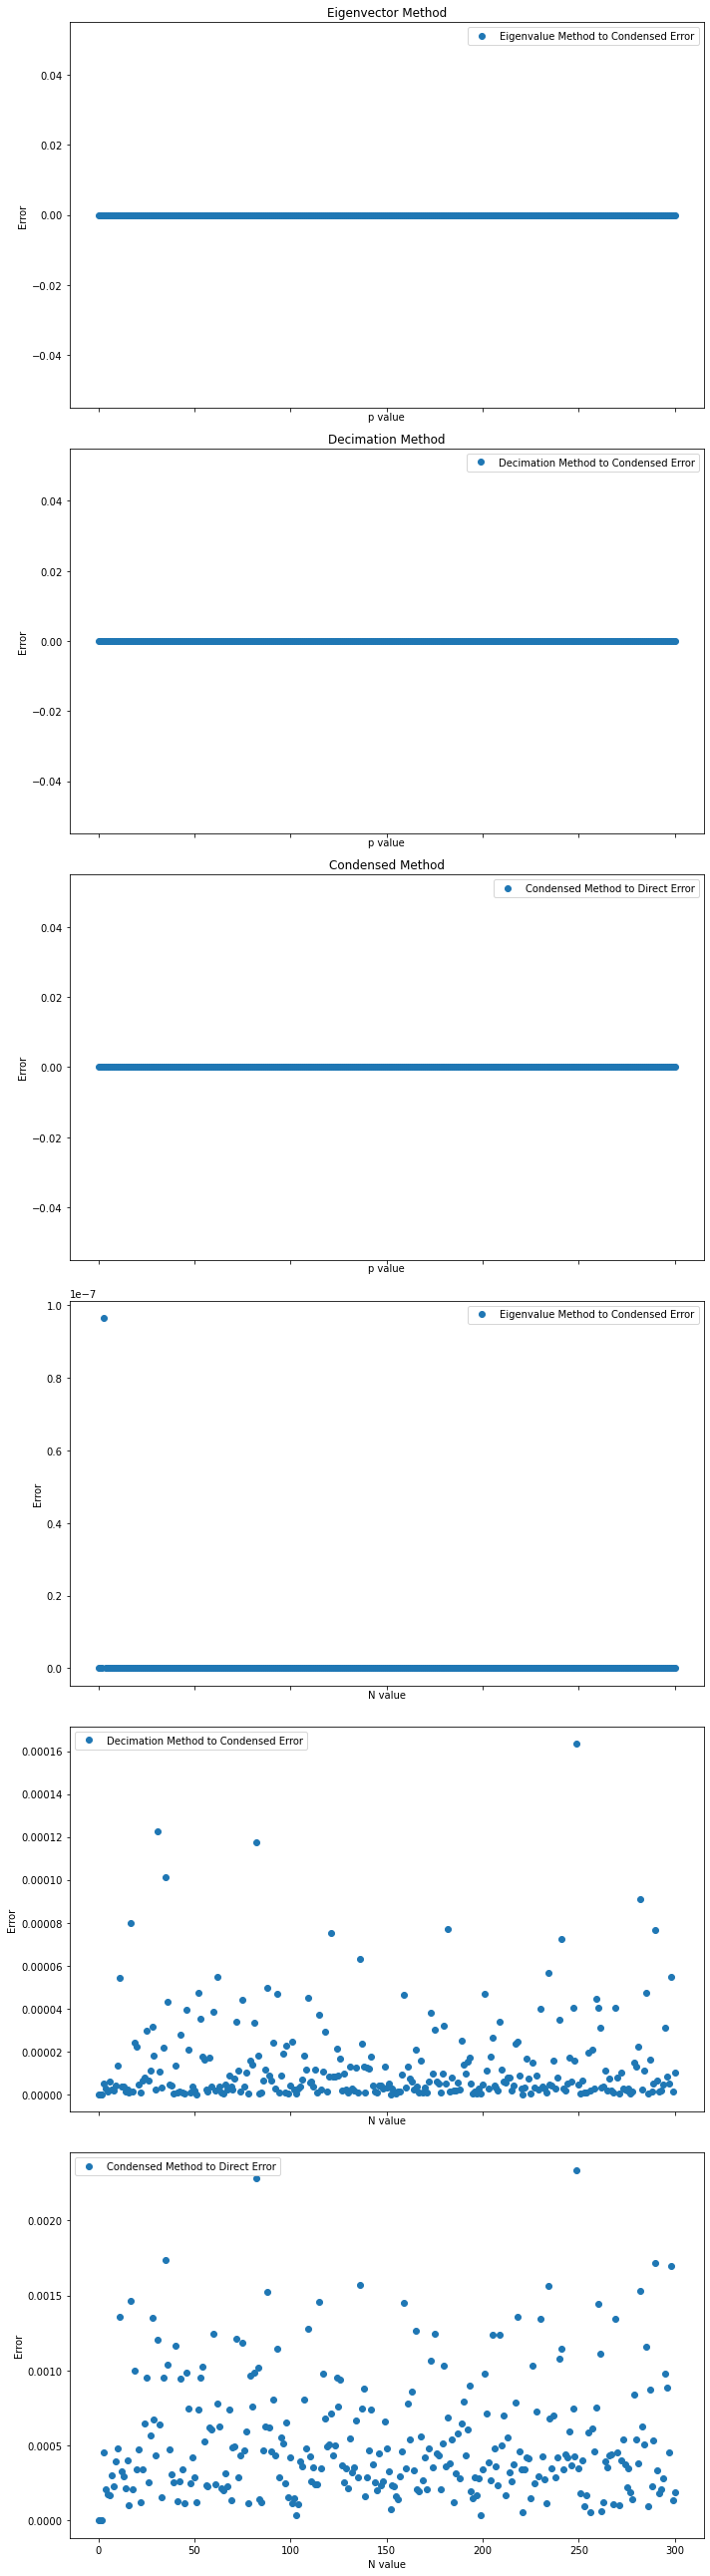

In [20]:
# Plotting 
fig, axs = plt.subplots(6, 1, figsize=(10, 36), sharex=True)

axs[0].plot(error_array_p[2,:],'o',label="Eigenvalue Method to Condensed Error")
axs[1].plot(error_array_p[3,:],'o',label="Decimation Method to Condensed Error")
axs[2].plot(error_array_p[4,:],'o',label="Condensed Method to Direct Error")

axs[3].plot(error_array_N[0,:],'o',label="Eigenvalue Method to Condensed Error")
axs[4].plot(error_array_N[3,:],'o',label="Decimation Method to Condensed Error")
axs[5].plot(error_array_N[5,:],'o',label="Condensed Method to Direct Error")



for i in range(0,3):
    axs[i].set_ylabel('Error')
    axs[i].set_xlabel('p value')
    axs[i].legend()
    
for i in range(3,6):
    axs[i].set_ylabel('Error')
    axs[i].set_xlabel('N value')
    axs[i].legend()    

axs[0].set_title('Eigenvector Method')
axs[1].set_title('Decimation Method')
axs[2].set_title('Condensed Method')

plt.tight_layout()
plt.show()    


In [21]:
surface_greens_func_calc_general(-2,10**-8,17,8,4,True,2.5,2.2287,0,False,True)

[[1.80427594+2.12266059j]]
Eigenvalue Method
Error from Cond
0.5331575309232214
Error from Direct
0.5331575232438124
Time
0.00033092498779296875
___________________________
Decimation Method
# Iterations before epsilon < 10^-8
18
Error from Cond
0.2928307728955269
Error from Direct
0.29283077698932886
Time
0.0006859302520751953
___________________________
Recursive Relation Datta
(-1.8694300345310646-3.7684043731096695e-07j)
Error from Direct
2.069102409656234
___________________________
Direct Condensed Method
Error from Direct
1.2055431855508165e-08
Time
0.00017070770263671875
___________________________
Direct Method
Time
3.24249267578125e-05
___________________________
Quadratic Formulation
(-0.21131585273811762+0.33962569233434137j)


[(-0.21131585403046163+0.3396256897102719j),
 (-0.07575740518548552-0.09943994812882348j),
 (-1.8694300345310646-3.7684043731096695e-07j),
 (-0.21131585273811762+0.33962569233434137j),
 (0.19967237512513786-2.8214166468217966e-08j),
 (0.19967237512513766-1.6158734612709803e-08j)]

In [22]:
matprint(Q)
matprint(R)
matprint(mul(inv(R),Q.T.conj()))

NameError: name 'Q' is not defined

In [31]:
# Test over several E values

Emin = -10
Emax = 0
stepsize = 0.01
Layers_probe = 40
Layers_device = 10
gamma_value = 2.5
beta_value = 2

ressults = np.zeros((int((Emax-Emin)/stepsize)+1,6),dtype=complex)
greens_func = np.zeros((int((Emax-Emin)/stepsize)+1,6,2*Layers_device,2*Layers_device),dtype=complex)

for i, E in enumerate(np.arange(Emin, Emax, stepsize)):
    ressults[i,:] = surface_greens_func_calc_general(E,10**-8,4,3,Layers_probe,True,gamma_value,beta_value,0.,False,False)
    #for k in range(6):
    #    greens_func[i,k,:,:] = Greens_1D(E, gamma_value, beta_value, ressults[i,k], Layers_device)

[[-0.02794215-3.45395411e-11j]]
[[-0.02803295-3.47018379e-11j]]
[[-0.02812415-3.48651154e-11j]]
[[-0.02821576-3.50293809e-11j]]
[[-0.02830777-3.5194642e-11j]]
[[-0.02840019-3.53609058e-11j]]
[[-0.02849303-3.552818e-11j]]
[[-0.02858628-3.56964722e-11j]]
[[-0.02867995-3.58657899e-11j]]
[[-0.02877403-3.60361409e-11j]]
[[-0.02886854-3.62075328e-11j]]
[[-0.02896347-3.63799737e-11j]]
[[-0.02905883-3.65534713e-11j]]
[[-0.02915462-3.67280337e-11j]]
[[-0.02925083-3.69036689e-11j]]
[[-0.02934748-3.70803851e-11j]]
[[-0.02944457-3.72581904e-11j]]
[[-0.0295421-3.74370931e-11j]]
[[-0.02964007-3.76171016e-11j]]
[[-0.02973848-3.77982242e-11j]]
[[-0.02983734-3.79804696e-11j]]
[[-0.02993664-3.81638463e-11j]]
[[-0.0300364-3.83483628e-11j]]
[[-0.03013661-3.85340281e-11j]]
[[-0.03023728-3.87208508e-11j]]
[[-0.03033841-3.890884e-11j]]
[[-0.03044-3.90980045e-11j]]
[[-0.03054206-3.92883534e-11j]]
[[-0.03064459-3.9479896e-11j]]
[[-0.03074758-3.96726413e-11j]]
[[-0.03085105-3.98665988e-11j]]
[[-0.03095499-4.006

[[-0.10885238-2.68353673e-10j]]
[[-0.10945415-2.7071918e-10j]]
[[-0.1100607-2.7311264e-10j]]
[[-0.11067208-2.75534478e-10j]]
[[-0.11128834-2.77985125e-10j]]
[[-0.11190953-2.80465019e-10j]]
[[-0.11253571-2.82974609e-10j]]
[[-0.11316693-2.8551435e-10j]]
[[-0.11380324-2.88084707e-10j]]
[[-0.1144447-2.90686153e-10j]]
[[-0.11509137-2.93319172e-10j]]
[[-0.11574331-2.95984256e-10j]]
[[-0.11640056-2.98681905e-10j]]
[[-0.1170632-3.01412632e-10j]]
[[-0.11773129-3.04176957e-10j]]
[[-0.11840487-3.06975412e-10j]]
[[-0.11908402-3.09808539e-10j]]
[[-0.1197688-3.12676891e-10j]]
[[-0.12045927-3.15581031e-10j]]
[[-0.1211555-3.18521534e-10j]]
[[-0.12185754-3.21498987e-10j]]
[[-0.12256547-3.24513987e-10j]]
[[-0.12327936-3.27567145e-10j]]
[[-0.12399927-3.30659083e-10j]]
[[-0.12472528-3.33790437e-10j]]
[[-0.12545744-3.36961855e-10j]]
[[-0.12619584-3.40173997e-10j]]
[[-0.12694055-3.4342754e-10j]]
[[-0.12769164-3.46723173e-10j]]
[[-0.12844919-3.50061598e-10j]]
[[-0.12921327-3.53443534e-10j]]
[[-0.12998396-3.5

[[-0.42972678+1.29677268j]]
[[-0.42089041+1.30360115j]]
[[-0.41203297+1.31037333j]]
[[-0.40315427+1.31709007j]]
[[-0.39425415+1.32375219j]]
[[-0.38533241+1.3303605j]]
[[-0.37638889+1.33691577j]]
[[-0.3674234+1.34341876j]]
[[-0.35843576+1.34987021j]]
[[-0.34942577+1.35627084j]]
[[-0.34039326+1.36262134j]]
[[-0.33133803+1.36892239j]]
[[-0.32225989+1.37517466j]]
[[-0.31315864+1.38137878j]]
[[-0.30403409+1.38753537j]]
[[-0.29488604+1.39364506j]]
[[-0.28571429+1.39970843j]]
[[-0.27651863+1.40572607j]]
[[-0.26729885+1.41169853j]]
[[-0.25805476+1.41762637j]]
[[-0.24878613+1.42351012j]]
[[-0.23949276+1.42935032j]]
[[-0.23017442+1.43514745j]]
[[-0.22083091+1.44090204j]]
[[-0.21146199+1.44661455j]]
[[-0.20206745+1.45228547j]]
[[-0.19264706+1.45791526j]]
[[-0.18320059+1.46350436j]]
[[-0.17372781+1.46905323j]]
[[-0.16422849+1.4745623j]]
[[-0.15470238+1.48003197j]]
[[-0.14514925+1.48546267j]]
[[-0.13556886+1.4908548j]]
[[-0.12596096+1.49620875j]]
[[-0.1163253+1.5015249j]]
[[-0.10666163+1.50680363j]

[[14.29332011+2.76638509e-06j]]
[[14.7443668+2.80359875e-06j]]
[[15.21408389+2.85608519e-06j]]
[[15.70451518+2.92306149e-06j]]
[[16.21782918+3.00427227e-06j]]
[[16.75636269+3.09988185e-06j]]
[[17.32266421+3.21041544e-06j]]
[[17.91953987+3.33673299e-06j]]
[[18.55010438+3.48002677e-06j]]
[[19.21783901+3.64183839e-06j]]
[[19.92665924+3.82409368e-06j]]
[[20.68099489+4.02915608e-06j]]
[[21.48588629+4.25990069e-06j]]
[[22.34710087+4.51981326e-06j]]
[[23.27127603+4.81312028e-06j]]
[[24.2660956+5.14495939e-06j]]
[[25.34051008+5.52160282e-06j]]
[[26.50501382+5.95075217e-06j]]
[[27.77199756+6.44193067e-06j]]
[[29.1562014+7.00701031e-06j]]
[[30.67530339+7.66092908e-06j]]
[[32.35069383+8.42267982e-06j]]
[[34.20850749+9.31669483e-06j]]
[[36.28101996+1.03748171e-05j]]
[[38.60856752+1.16391602e-05j]]
[[41.24223483+1.31663464e-05j]]
[[44.24769433+1.50339349e-05j]]
[[47.71081769+1.73504398e-05j]]
[[51.74609267+2.02714212e-05j]]
[[56.50963119+2.40262552e-05j]]
[[62.21998185+2.8964522e-05j]]
[[69.1928176

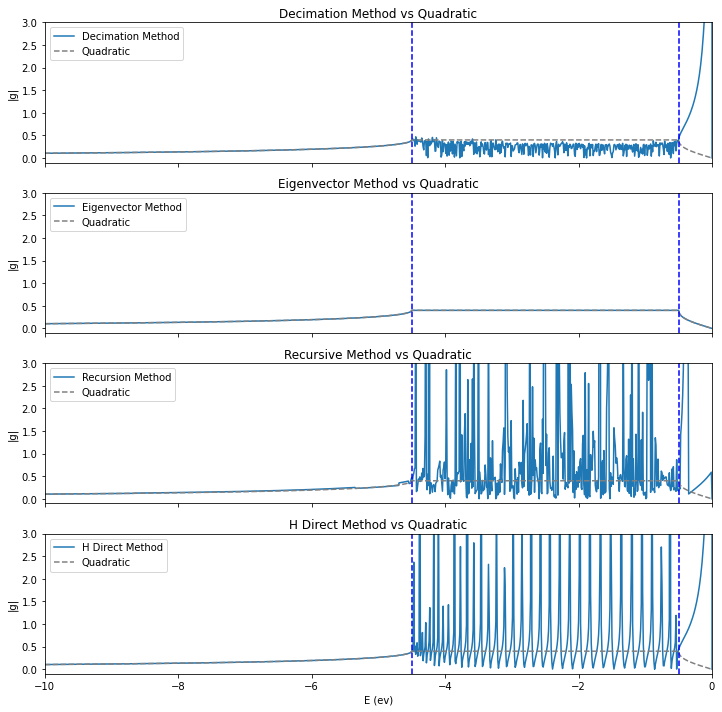

In [32]:
# Plotting 

x_values = np.linspace(Emin, Emax, int((Emax - Emin) / stepsize) + 1)

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x_values, abs(abs(ressults[:, 1])), label="Decimation Method")
axs[1].plot(x_values, abs(abs(ressults[:, 0])), label="Eigenvector Method")
axs[2].plot(x_values, abs(abs(ressults[:, 2])), label="Recursion Method")
axs[3].plot(x_values, abs(abs(ressults[:, 4])), label="H Direct Method")

# Plotting the quadratic case in each subplot
for ax in axs:
    ax.plot(x_values, abs(abs(ressults[:, 3])), label="Quadratic", linestyle='--', color='gray')

# Adding vertical lines
for ax in axs:
    ax.axvline(x=-(beta_value + gamma_value), color='b', linestyle='--')
    ax.axvline(x=-(-beta_value + gamma_value), color='b', linestyle='--')

axs[3].set_xlabel('E (ev)')
for ax in axs:
    ax.set_ylabel('|g|')
    ax.set_xlim(Emin, Emax)
    ax.set_ylim(-0.1, 3)
    ax.legend()

axs[0].set_title('Decimation Method vs Quadratic')
axs[1].set_title('Eigenvector Method vs Quadratic')
axs[2].set_title('Recursive Method vs Quadratic')
axs[3].set_title('H Direct Method vs Quadratic')

plt.tight_layout()
plt.show()

In [33]:
# Inversion of C matrix recursively
C = H[n:P*n,n:P*n]
C_tilde = inv(E*np.diag(np.ones((P-1)*n))-C)

H_tilde = np.zeros((n,n,P,P),dtype=complex)
H_tilde[:,:,P-1,P-1] = inv(E*np.diag(np.ones(n))-alpha[:,:,P-1])

for i in range(P-2,0,-1):
    H_tilde[:,:,i,i] = inv(E*np.diag(np.ones(n))-alpha[:,:,i]-mul(tau[:,:,i],mul(H_tilde[:,:,i+1,i+1],tau[:,:,i].T.conj())))
    H_tilde[:,:,i,P-1] = mul(H_tilde[:,:,i,i],mul(tau[:,:,i],H_tilde[:,:,i+1,P-1]))

C_find_tilde = np.zeros((n,n,P),dtype=complex)
C_find_tilde[:,:,1] = H_tilde[:,:,1,1]

for i in range(2,P):
    C_find_tilde[:,:,i] = H_tilde[:,:,i,i]+mul(H_tilde[:,:,i,i],mul(mul(tau[:,:,i-1].T.conj(),mul(C_find_tilde[:,:,i-1],tau[:,:,i-1])),H_tilde[:,:,i,i]))  

print("Top left elements")
matprint(H_tilde[:,:,1,1])
matprint(C_tilde[0:n,0:n])
print("_________________________________")
print("Top right elements")
matprint(C_tilde[0:n,(P-2)*n:(P-1)*n])
matprint(H_tilde[:,:,1,P-1])
print("Bottom right elements")
print("_________________________________") 
matprint(C_find_tilde[:,:,P-1])
matprint(C_tilde[(P-2)*n:(P-1)*n,(P-2)*n:(P-1)*n])


NameError: name 'H' is not defined

In [34]:
theta = np.zeros((n,n,P),dtype=complex)
theta[:,:,0] = np.diag(np.ones(n))
theta[:,:,1] = mul(inv(tau[:,:,1]),alpha[:,:,1])

for i in range(2,P-1):
    theta[:,:,i] = mul(inv(tau[:,:,i]),mul(alpha[:,:,i],theta[:,:,i-1]))-mul(inv(tau[:,:,i]),mul(tau[:,:,i-1].T.conj(),theta[:,:,i-2],))

        


phi = np.zeros((n,n,P+1),dtype=complex)
phi[:,:,P] = np.diag(np.ones(n))
phi[:,:,P-1] = mul(inv(tau[:,:,P-2].T.conj()),alpha[:,:,P-1])
    
for i in range(P-2,1,-1):
    phi[:,:,i] = mul(inv(tau[:,:,i-1].T.conj()),mul(alpha[:,:,i],phi[:,:,i+1]))-mul(inv(tau[:,:,i-1].T.conj()),mul(tau[:,:,i],phi[:,:,i+2]))
      

C_tilde_11 = inv(alpha[:,:,1]-mul(tau[:,:,1],mul(phi[:,:,3],inv(phi[:,:,2]))))
C_tilde_nn = inv(alpha[:,:,P-2]-mul(tau[:,:,P-1].T.conj(),mul(theta[:,:,P-3],inv(theta[:,:,P-2]))))

matprint(C_tilde_11)
        
C_tilde_real = inv(C)
    
matprint(C_tilde_real[0:n,0:n])
matprint(C_tilde_real)

NameError: name 'n' is not defined